Tendrás que crear una función que use las partículas de un filtro para estimar la posición y orientación de un robot y guiarlo hasta una posición determinada.

Lee atentamente las siguientes celdas. El ejercicio está más abajo.

Usamos un robot de manera análoga al ejercicio anterior

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

%run -i code/filter.py
lmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
wsize   = 100.0


myrobot = RobotPosition(lmarks, wsize)
myrobot.x, myrobot.y = 70,70
myrobot.sense_noise  = 2.
print (myrobot)
print (myrobot.sense())
print (myrobot.sense())
print (myrobot.sense())

[x=70 y=70 orient=0.4811]
[72.0463632196604, 11.9719432416092, 49.84833062197758, 50.22847271755628]
[69.7166290281421, 15.397172496440092, 50.3655118543185, 52.00145319321513]
[69.65895209452542, 11.820059175428685, 54.45539062152498, 50.24598787333754]


Copia aquí las funciones que creaste en el ejercicio anterior

In [2]:
def Gaussian(mu, sigma, x):
    # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
    return np.exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / np.sqrt(2.0 * pi * (sigma ** 2))


def measurement_prob(particle, measurement):

    # calculates how likely a measurement should be
    
    #measurement->lista con tantos elementos como balizas,contiene la medida realizada por un robot a cada una de las balizas
    #[65.78568637695668, 21.16196116730348, 50.83054683619303, 49.59328462505256] ejemplo measurement
    """
    Este es el d^r = {d^r_1, d^r_2, d^r_3, d^r_4}
    particle.sense() -> d^p = { d^p_1, d^p_2, d^p_3, d^p_4}
    """
    
    #particle para landmarks ->lista de tuplas con las posiciones de las balizas.
    #landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]] ejemplo particle.landmarks
    
    prob = 1.0
    #dist_particles = particle.sense()
    for i in range(len(particle.landmarks)):
        dist_particles = particle.sense()
        prob*=Gaussian(measurement[i],5,dist_particles[i])
    return prob

def weighted_sample(weight_list, n_samples=None):    
    if n_samples is None:
        n_samples=len(weight_list)
    
    result = []
    # -- TU CODIGO AQUI ---
    result=np.random.choice(len(weight_list), n_samples, p=weight_list)
    # -----
    return result


Fïjate como movemos el robot usando un filtro de partículas

In [3]:
def trayectory(n_particles, max_steps, landmarks, world_size, next_move, init_pos, plot_steps=False):
    N = n_particles

    myrobot = RobotPosition(landmarks, world_size)
    myrobot.set_noise(0.05, 0.05, 1.0)

    myrobot.x, myrobot.y = init_pos
    print (myrobot)

    robot_positions = [myrobot]

    # SE CREA UN CONJUNTO DE PARTICULAS
    p = []
    for i in range(N):
        r = RobotPosition(landmarks, world_size)
        r.set_noise(myrobot.forward_noise, myrobot.turn_noise, myrobot.sense_noise)
        p.append(r)

    if plot_steps:
        x_plots = 5
        y_plots = np.ceil((max_steps+1)*1./5)
        fig = plt.figure( figsize = (3*x_plots, 3*y_plots))
        fig.add_subplot( y_plots, x_plots, 1)
        plot_world(world_size, landmarks, robot_position=myrobot, particles=p, show_pct=0.1, no_title=True)

    errs_mean = []
    errs_std  = []
    parts_std = []
    for t in range(max_steps):
        
        # PASO 1: MOVEMOS ROBOT Y PARTICULAS DE LA MISMA MANERA
        mh, md = next_move(p)
        if mh is None or md is None:
            print ("target reached in",t,"steps")
            break
        myrobot = myrobot.move(mh, md)
        p2 = []
        for i in range(N):
            p2.append(p[i].move(mh, md))
        p = p2

        # PASO 2: OBTENEMOS LAS DISTANCIAS DEL ROBOT A LAS BALIZAS
        robot_positions.append(myrobot)
        Z = myrobot.sense()

        # PASO 3: PARA CADA PARTICULA, OBTENEMOS LA PROBABILIDAD DE OBTENER 
        #         LA MEDICION QUE OBTUVO EL ROBOT
        w = []
        for i in range(N):
            w.append(measurement_prob(p[i], Z))

        # PASO 4: MUESTREAMOS CON REEMPLAZO LAS PARTICULAS CON PROBABILIDAD
        #         PROPORCIONAL A LO OBTENIDO EN EL PASO ANTERIOR
        p3 = []
        w = w/np.sum(w)
        resample = weighted_sample(w)
        for i in resample:
            p3.append(p[i])
        p = p3

        # FINALIZACION ITERACION: MEDIMOS EL ERROR MEDIO DE LAS PARTICULAS
        # Y LA DESV ESTANDAR DE SUS POSICIONES
        er, es, stds = eval(myrobot,p, wsize)
        errs_mean.append(er)
        errs_std.append(es)
        parts_std.append(stds)
        if plot_steps:
            fig.add_subplot( y_plots, x_plots, t+2)
            plot_world(world_size, landmarks, robot_position=myrobot, particles=p, show_pct=0.1, no_title=True)
        
    print (myrobot)

    return robot_positions, p, errs_mean, errs_std, parts_std


La función `move_forward` decide en cada paso cuanto girar y cuando avanzar el robot

[x=50 y=50 orient=3.7330]
[x=54.319 y=55.714 orient=0.2061]


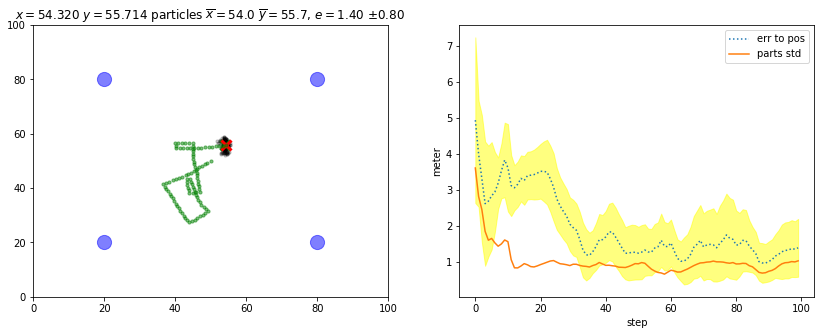

In [4]:
def move_forward(particles):
    turn = np.pi/2 if np.random.random() >0.9 else 0
    forward = 1
    return turn, forward

lmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]#, [50., 50.], [50., 20.]]
wsize = 100.0
robot_positions, particles, errs_mean, errs_std, parts_std = trayectory(n_particles=1000, max_steps=100, 
                                                                        landmarks=lmarks, world_size=wsize,
                                                                        next_move=move_forward,
                                                                        init_pos = [50,50])
plot_all(wsize, lmarks, robot_positions, particles, errs_mean, errs_std, parts_std)

[x=50 y=50 orient=2.9114]
[x=57.409 y=92.698 orient=4.4284]


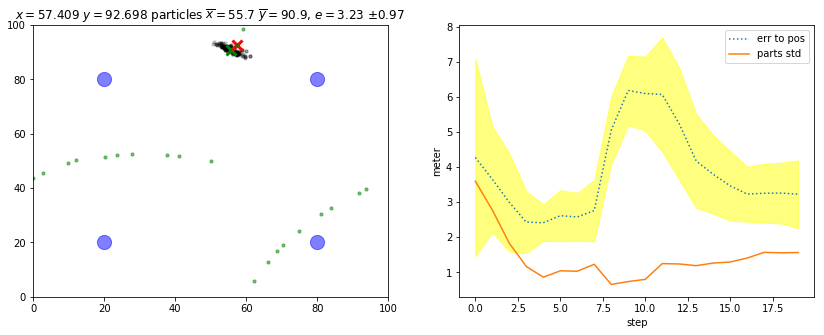

In [133]:
def move_random(particles):
    return np.random.random()*0.2, np.random.random()*10.+1

lmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]#, [50., 50.], [50., 20.]]
wsize = 100.0
robot_positions, particles, errs_mean, errs_std, parts_std = trayectory(n_particles=1000, max_steps=20, 
                                                                        landmarks=lmarks, world_size=wsize,
                                                                        next_move=move_random,
                                                                        init_pos = [50,50])
plt.figure()
plot_all(wsize, lmarks, robot_positions, particles, errs_mean, errs_std, parts_std)

### Problema EXTRA

Implementa la función `move_to_target` que use el conjunto de partículas decidir el siguiente movimiento del robot para llevarlo al punto [10, 50]

Resultado esperado

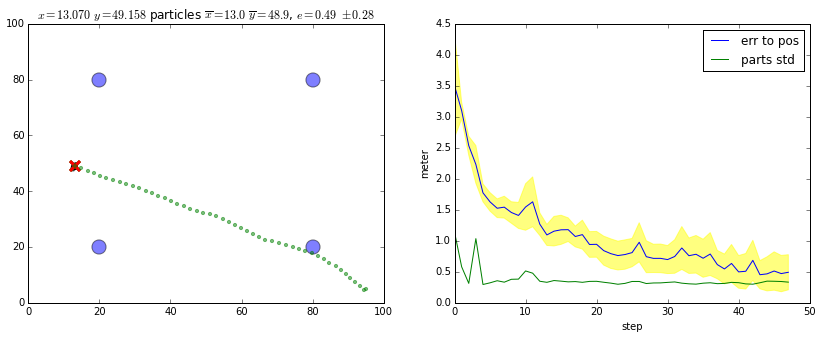

In [5]:
from IPython.display import Image
Image(filename='imgs/particle-1.png')

[x=95 y=5 orient=3.0207]
target reached in 35 steps
[x=8.9251 y=50.504 orient=0.4818]
0.5415506558 0.611251407156


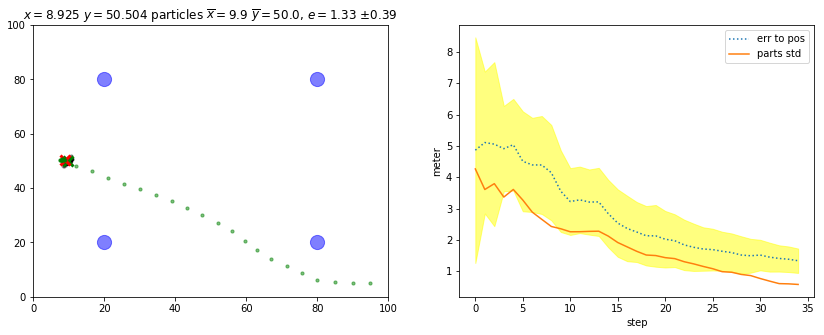

In [6]:
flag = True
def move_to_target( particles ):
    target_point = [10,50]
    sx, sy = np.std(np.array([[p.x,p.y] for p in particles]), axis=0)
    mx, my, o = np.mean(np.array([[p.x,p.y, p.orientation] for p in particles]), axis=0)
    turn, forward = 0,0
    if(np.abs(10-mx)<0.1 and np.abs(50-my)<0.1):
        return None,None
    if(np.abs(10-mx)<2 and np.abs(50-my)<2):
        turn = (360*np.pi/180-o) +np.arctan2(50-my,10-mx)
        forward = 0.1
        return turn,forward

    turn = (360*np.pi/180-o) +np.arctan2(50-my,10-mx)
    forward = 5
    return turn,forward
    
lmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]] #, [50., 50.], [50., 20.]]
wsize = 100.0
robot_positions, particles, errs_mean, errs_std, parts_std = trayectory(n_particles=1000, max_steps=200, 
                                                                        landmarks=lmarks, world_size=wsize,
                                                                        next_move=move_to_target, 
                                                                        init_pos = [95,5])
plt.figure()
plot_all(wsize, lmarks, robot_positions, particles, errs_mean, errs_std, parts_std)
sx, sy = np.std(np.array([[p.x,p.y] for p in particles]), axis=0)
print(sx,sy)